In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F



In [2]:
DF = pd.read_csv('weatherAUS.csv')

In [3]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
cols = ['Rainfall','Humidity3pm', 'Pressure9am','RainToday', 'RainTomorrow']
df=DF[cols]

In [5]:
# WE WILL CONVERT 'YES' and 'NO' to 1 AND 0
df['RainToday'].replace({'No':0, 'Yes':1}, inplace=True)
df['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace=True)

/tmp/ipykernel_41261/225823039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainToday'].replace({'No':0, 'Yes':1}, inplace=True)
/tmp/ipykernel_41261/225823039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace=True)


In [6]:
#DROP ROWS WITH MISSING VALUES
df= df.dropna(how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124689 entries, 0 to 145458
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Rainfall      124689 non-null  float64
 1   Humidity3pm   124689 non-null  float64
 2   Pressure9am   124689 non-null  float64
 3   RainToday     124689 non-null  float64
 4   RainTomorrow  124689 non-null  float64
dtypes: float64(5)
memory usage: 5.7 MB


/home/kaliw/GITHUB/PYTORCH/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

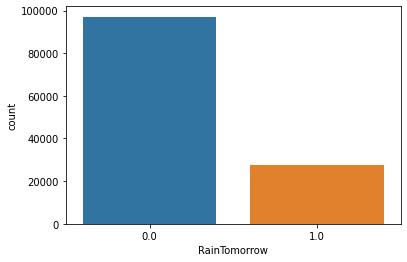

In [7]:
sns.countplot(df.RainTomorrow)

In [8]:
df.RainTomorrow.value_counts()/df.shape[0]

0.0    0.778762
1.0    0.221238
Name: RainTomorrow, dtype: float64

In [9]:
X= df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y= df[['RainTomorrow']]

x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#CONVERT ALL OF IT TO TENSORS 
X_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


## CREATE A NEURAL NETWORK

In [12]:
class Net(nn.Module):
    
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 5)
        self.fc2 = nn.Linear(5, 3)
        self.fc3 = nn.Linear(3,1)
        
    def forward(self, x):
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))
    
net =Net(X_train.shape[1])


## Training the MODEL

In [13]:
criterion = nn.BCELoss() ## Measures the firrences between 2 binary vectors: The predictions of our model
# and the real values. It expects values to be outputed by the sigmoid function.

### OPTIMIZING

In [14]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

### DOING IT ON THE GPU!

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [22]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

net = net.to(device)
criterion= criterion.to(device)

## FINDING GOOD PARAMETERS
### ACURACY:

In [17]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

### TRAINING THE MODEL:

In [24]:
def round_tensor(t, decimal_places = 3):
    return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
        
        train_acc= calculate_accuracy(y_train, y_pred)
        
        y_test_pred = net(X_test)
        y_test_pred = torch.squeeze(y_test_pred)
        
        test_loss = criterion(y_test_pred, y_test)
        test_acc = calculate_accuracy(y_test, y_test_pred)
        
        print(f'''epoch {epoch} 
            Train Set - loss : {round_tensor(train_loss)}, accuracy : {round_tensor(train_acc)}
            Tet Set - loss : {round_tensor(test_loss)}, accuracy : {round_tensor(test_acc)}''')
        
        optimizer.zero_grad()
        
        train_loss.backward()
        
        optimizer.step()

epoch 0 
            Train Set - loss : 22.116, accuracy : 0.779
            Tet Set - loss : 22.155, accuracy : 0.778
epoch 100 
            Train Set - loss : 22.116, accuracy : 0.779
            Tet Set - loss : 22.155, accuracy : 0.778
epoch 200 
            Train Set - loss : 22.116, accuracy : 0.779
            Tet Set - loss : 22.155, accuracy : 0.778
epoch 300 
            Train Set - loss : 22.116, accuracy : 0.779
            Tet Set - loss : 22.155, accuracy : 0.778
epoch 400 
            Train Set - loss : 22.116, accuracy : 0.779
            Tet Set - loss : 22.155, accuracy : 0.778
epoch 500 
            Train Set - loss : 22.116, accuracy : 0.779
            Tet Set - loss : 22.155, accuracy : 0.778
epoch 600 
            Train Set - loss : 22.116, accuracy : 0.779
            Tet Set - loss : 22.155, accuracy : 0.778
epoch 700 
            Train Set - loss : 22.116, accuracy : 0.779
            Tet Set - loss : 22.155, accuracy : 0.778
epoch 800 
            Train Set -

### SAVING THE MODEL

In [19]:
MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

### RESTORING THE MODEL

In [ ]:
net = torch.load(MODEL_PATH)

# EVALUATING THE MODEL'S ERROS

In [25]:
# Asses the preccsion and recall for each class

classes = ['No rain', 'Raining']

y_pred= net(X_test)

y_pred= y_pred.ge(.5).view(-1).cpu()
y_test= y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.78      1.00      0.88     19413
     Raining       0.00      0.00      0.00      5525

    accuracy                           0.78     24938
   macro avg       0.39      0.50      0.44     24938
weighted avg       0.61      0.78      0.68     24938



/home/kaliw/GITHUB/PYTORCH/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaliw/GITHUB/PYTORCH/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaliw/GITHUB/PYTORCH/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


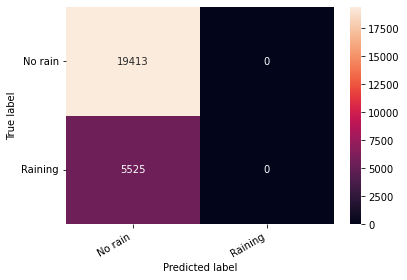

In [26]:
cm = confusion_matrix(y_test, y_pred)

df_cm= pd.DataFrame(cm, index=classes, columns=classes)

hmap= sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');